# 1. Observations on 1 pixel kernel

In Line (I), the operation ```self.in2out = nn.Conv2d(in_ch, out_ch, 1)``` is used to change the number of channels from in_ch to out_ch. By using a 1×1 kernel, this convolution applies a transformation independently to each pixel across channels. Instead of considering neighboring pixels, it performs a per-pixel operation, essentially appling learned linear transformation to each pixel's channel values. This allows for a channel-wise transformation while preserving spatial structure.

In Lines (K) and (L), the operations ```self.downsampler1 = nn.Conv2d(in_ch, in_ch, 1, stride=2)``` and ```self.downsampler2 = nn.Conv2d(out_ch, out_ch, 1, stride=2)``` serve as downsamplers. By setting stride=2, the convolution layer skips every other pixel in both the width and height dimensions. This results in a reduction of spatial resolution while performing a per-pixel linear transformation across channels. Unlike conventional convolution, which considers spatial neighbors, this method reduces the number of pixels processed while retaining key features.

The reason why Lines (I), (K), and (L) make sense in using a 1×1 kernel is that they perform a linear transformation at each pixel location while maintaining spatial information. Line (I) adjusts the number of channels without altering spatial dimensions, whereas Lines (K) and (L) downsample the feature map while preserving channel-wise structure. 


# 2. BMENet with maxpool

In [1]:
import os, sys
print(os.getcwd())
sys.path.append("./../DLStudio-2.5.1")

# from DLStudio import *

/home/chen4126/ece60146/HW6


Files already downloaded and verified
Files already downloaded and verified


The number of learnable parameters in the model: 30092354


Starting training loop...



[epoch:1/10  iter=1000  elapsed_time=   25 secs]   Ground Truth:           bird      plane       frog       ship        car       deer       frog       ship       deer      horse       bird       deer       frog        car        dog       ship
[epoch:1/10  iter=1000  elapsed_time=   25 secs]   Predicted Labels:      plane      plane        car        car        car       deer       deer       deer        dog        dog       bird        cat        dog        dog        dog       bird
[epoch:1/10  iter=1000  elapsed_time=   25 secs]   Loss: 2.278


[epoch:1/10  iter=2000  elapsed_time=   51 secs]   Ground Truth:           frog      plane        dog      truck        cat      horse        car       bird       deer       deer        car       frog      horse       bird      horse      horse
[epoch:1/10  iter=2000  elapsed_t

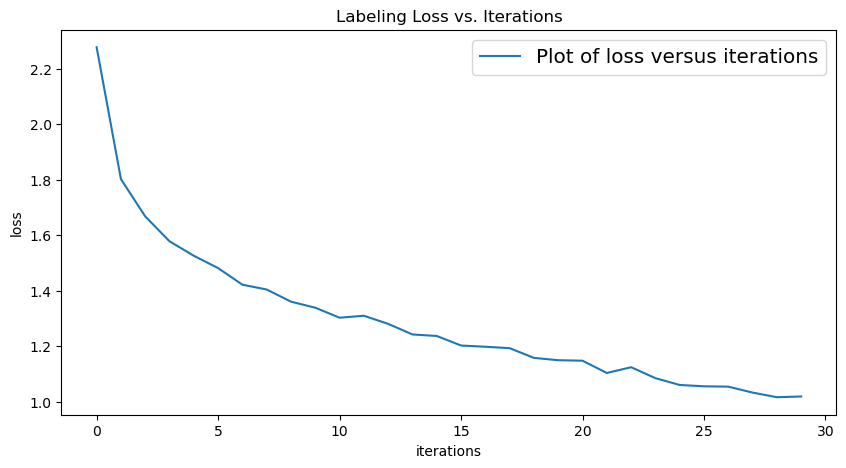

Prediction accuracy for plane : 65 %
Prediction accuracy for   car : 79 %
Prediction accuracy for  bird : 37 %
Prediction accuracy for   cat : 52 %
Prediction accuracy for  deer : 61 %
Prediction accuracy for   dog : 35 %
Prediction accuracy for  frog : 68 %
Prediction accuracy for horse : 70 %
Prediction accuracy for  ship : 81 %
Prediction accuracy for truck : 77 %



Overall accuracy of the network on the 10000 test images: 62 %


Displaying the confusion matrix:

           plane    car   bird    cat   deer    dog   frog  horse   ship  truck

 plane:    65.40   4.10   2.70   2.20   2.70   0.30   1.00   1.30  12.20   8.10
   car:     1.40  79.10   0.20   0.40   0.50   0.10   0.60   0.10   2.40  15.20
  bird:     9.80   2.20  37.30  11.20  17.30   5.20   5.00   4.50   4.30   3.20
   cat:     2.90   1.40   5.00  52.40  10.10   7.90   6.70   5.40   2.80   5.40
  deer:     2.50   0.80   5.80   7.60  61.60   2.20   5.60  11.00   1.60   1.30
   dog:     1.70   0.80   5.10  31.20   8.90  3

In [4]:
import torch.nn as nn
from DLStudio import DLStudio
import torch

# this code is mainly borrowed from DLstudio, the code that i modify has a comment behind
class BMEnetModifiedForMaxpool(nn.Module):
    def __init__(self, dl_studio, skip_connections=True, depth=8):
        super().__init__()

        self.dl_studio = dl_studio
        self.depth = depth
        image_size = dl_studio.image_size
        ## num_ds stands for number of downsampling steps
        num_ds = 0                  

        self.conv = nn.Conv2d(3, 64, 3, padding=1)

        # layers of skipblock without downsample
        self.skip64_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip64_arr.append(self.SkipBlock(64, 64, skip_connections=skip_connections)) 
        # a skipblock with downsample
        self.skip64to128ds = self.SkipBlock(64, 128, downsample=True, skip_connections=skip_connections ) 
        num_ds += 1      

        self.skip128_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip128_arr.append(self.SkipBlock(128, 128, skip_connections=skip_connections))
        self.skip128to256ds = self.SkipBlock(128, 256, downsample=True, skip_connections=skip_connections )
        num_ds += 1

        self.skip256_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip256_arr.append(self.SkipBlock(256, 256, skip_connections=skip_connections))

        self.fc1 =  nn.Linear( (image_size[0]// (2 ** num_ds))  *  (image_size[1]//(2 ** num_ds))  * 256, 1000)
        self.fc2 =  nn.Linear(1000, 10)



    def forward(self, x):
        x = nn.functional.relu(self.conv(x))          
        for skip64 in self.skip64_arr:
            x = skip64(x)                
        x = self.skip64to128ds(x)
        for skip128 in self.skip128_arr:
            x = skip128(x)                
        x = self.skip128to256ds(x)
        for skip256 in self.skip256_arr:
            x = skip256(x)                
        x  =  x.view( x.shape[0], - 1 )
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x            

    def load_cifar_10_dataset(self):       
        self.dl_studio.load_cifar_10_dataset()

    def load_cifar_10_dataset_with_augmentation(self):             
        self.dl_studio.load_cifar_10_dataset_with_augmentation()




    class SkipBlock(nn.Module):        
        def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
            super().__init__()
            self.downsample = downsample
            self.skip_connections = skip_connections
            self.in_ch = in_ch
            self.out_ch = out_ch
            self.convo1 = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
            self.convo2 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm2d(in_ch)
            self.bn2 = nn.BatchNorm2d(out_ch)
            self.in2out  =  nn.Conv2d(in_ch, out_ch, 1)       
            if downsample:
                self.maxpool = nn.MaxPool2d(2, 2) # do maxpool


        def forward(self, x):
            # identity holds the original input tensor to the skip block
            identity = x                                     
            out = self.convo1(x)                              
            out = self.bn1(out)                              
            out = nn.functional.relu(out)
            out = self.convo2(out)                              
            out = self.bn2(out)                              
            out = nn.functional.relu(out)


            # Apply downsampling if needed
            if self.downsample:
                identity = self.maxpool(identity)       # channel still input size 
                out = self.maxpool(out)                #  channel still output size
                
            # Handle skip connections
            if self.skip_connections:
                if (self.in_ch == self.out_ch) and (self.downsample is False):
                    out = out + identity
                elif (self.in_ch != self.out_ch) and (self.downsample is False):
                    identity = self.in2out( identity )     
                    out = out + identity
                elif (self.in_ch != self.out_ch) and (self.downsample is True):
                    out = out + torch.cat((identity, identity), dim=1)

            return out


    def run_code_for_training(self, net, display_images=False):        
        self.dl_studio.run_code_for_training(net, display_images)
        
    def save_model(self, model):
        '''
        Save the trained model to a disk file
        '''
        torch.save(model.state_dict(), self.dl_studio.path_saved_model)

    def run_code_for_testing(self, model, display_images=False):
        self.dl_studio.run_code_for_testing(model, display_images=False)


dls = DLStudio(
#                  dataroot = "/home/kak/ImageDatasets/CIFAR-10/",
                dataroot = "./../data/CIFAR-10/",
                image_size = [32,32],
                path_saved_model = "./saved_model",
                momentum = 0.9,
                learning_rate = 1e-5,
                epochs = 10,
                batch_size = 16,
                classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck'),
                use_gpu = True,
            )

bme_net = BMEnetModifiedForMaxpool(dls, skip_connections=True, depth=8)         ## if you want to use skips

bme_net.load_cifar_10_dataset()

## display network properties
number_of_learnable_params = sum(p.numel() for p in bme_net.parameters() if p.requires_grad)
print("\n\nThe number of learnable parameters in the model: %d" % number_of_learnable_params)

## training and testing
bme_net.run_code_for_training(bme_net, display_images=False)
bme_net.run_code_for_testing(bme_net, display_images=False)


### 2.1 Train loss curve

### 2.2 Confusion Matrix
|        | Plane | Car  | Bird | Cat  | Deer | Dog  | Frog | Horse | Ship | Truck |
|--------|-------|------|------|------|------|------|------|-------|------|-------|
| **Plane** | 65.40 | 4.10 | 2.70 | 2.20 | 2.70 | 0.30 | 1.00 | 1.30  | 12.20 | 8.10  |
| **Car**   | 1.40  | 79.10 | 0.20 | 0.40 | 0.50 | 0.10 | 0.60 | 0.10  | 2.40  | 15.20 |
| **Bird**  | 9.80  | 2.20 | 37.30 | 11.20 | 17.30 | 5.20 | 5.00 | 4.50  | 4.30  | 3.20  |
| **Cat**   | 2.90  | 1.40 | 5.00 | 52.40 | 10.10 | 7.90 | 6.70 | 5.40  | 2.80  | 5.40  |
| **Deer**  | 2.50  | 0.80 | 5.80 | 7.60 | 61.60 | 2.20 | 5.60 | 11.00 | 1.60  | 1.30  |
| **Dog**   | 1.70  | 0.80 | 5.10 | 31.20 | 8.90 | 35.50 | 2.40 | 8.80  | 2.70  | 2.90  |
| **Frog**  | 0.60  | 1.70 | 4.00 | 8.50 | 10.20 | 0.40 | 68.20 | 1.60  | 1.50  | 3.30  |
| **Horse** | 1.40  | 0.60 | 2.00 | 7.10 | 8.10 | 3.20 | 1.00 | 70.00 | 0.60  | 6.00  |
| **Ship**  | 4.90  | 5.40 | 0.20 | 0.90 | 0.70 | 0.00 | 0.50 | 0.80  | 81.90 | 4.70  |
| **Truck** | 2.30  | 12.30 | 0.40 | 1.60 | 0.70 | 0.00 | 0.80 | 1.10  | 3.10  | 77.70 |


# 3. BMENet with stride

ter=3000  elapsed_time=   93 secs]   Loss: 1.641


[epoch:1/6  iter=4000  elapsed_time=  122 secs]   Ground Truth:          horse      plane       ship        dog
[epoch:1/6  iter=4000  elapsed_time=  122 secs]   Predicted Labels:       ship      plane       ship       frog
[epoch:1/6  iter=4000  elapsed_time=  122 secs]   Loss: 1.556


[epoch:1/6  iter=5000  elapsed_time=  151 secs]   Ground Truth:          plane       bird      plane        car
[epoch:1/6  iter=5000  elapsed_time=  151 secs]   Predicted Labels:      plane       frog        dog        car
[epoch:1/6  iter=5000  elapsed_time=  151 secs]   Loss: 1.478


[epoch:1/6  iter=6000  elapsed_time=  181 secs]   Ground Truth:          plane       ship       deer        cat
[epoch:1/6  iter=6000  elapsed_time=  181 secs]   Predicted Labels:       bird       ship        dog        cat
[epoch:1/6  iter=6000  elapsed_time=  181 secs]   Loss: 1.384


[epoch:1/6  iter=7000  elapsed_time=  210 secs]   Ground Truth:           ship      h

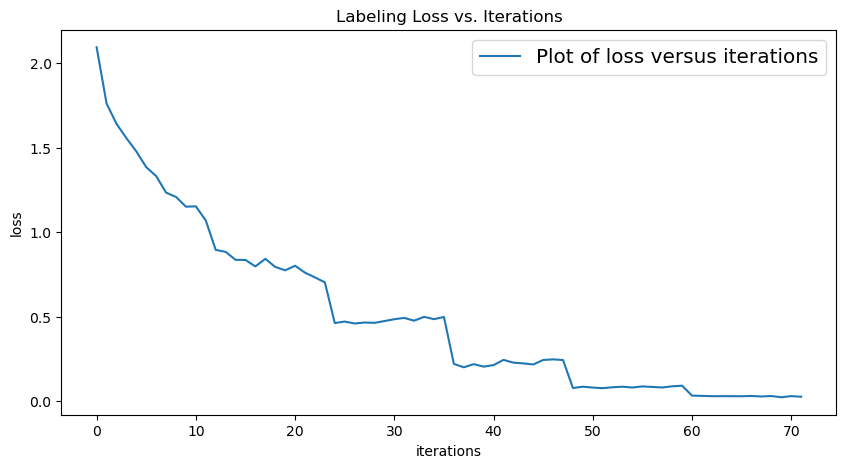

/home/chen4126/ece60146/HW6/./../DLStudio-2.5.1/DLStudio/DLStudio.py:2964: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(self.path_saved_model

In [3]:
dls = DLStudio(
#                  dataroot = "/home/kak/ImageDatasets/CIFAR-10/",
                dataroot = "./../data/CIFAR-10/",
                image_size = [32,32],
                path_saved_model = "./saved_model",
                momentum = 0.9,
                learning_rate = 1e-4,
                epochs = 6,
                batch_size = 4,
                classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck'),
                use_gpu = True,
            )

bme_net = dls.BMEnet(dls, skip_connections=True, depth=8)         ## if you want to use skips

bme_net.load_cifar_10_dataset()

## display network properties
number_of_learnable_params = sum(p.numel() for p in bme_net.parameters() if p.requires_grad)
print("\n\nThe number of learnable parameters in the model: %d" % number_of_learnable_params)

## training and testing
bme_net.run_code_for_training(bme_net, display_images=False)
bme_net.run_code_for_testing(bme_net, display_images=False)


### 3.1 Train loss curve
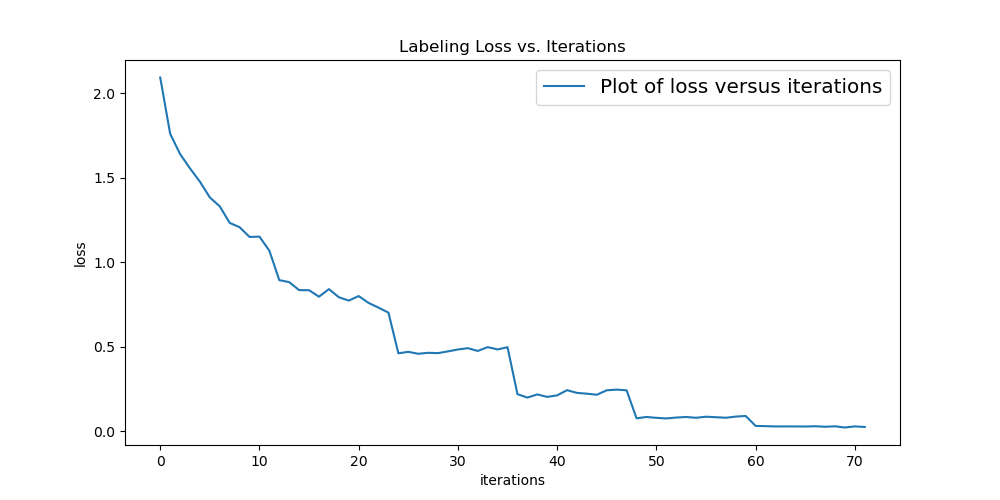

### 3.2 Confusion Matrix
|        | Plane  | Car   | Bird  | Cat   | Deer  | Dog   | Frog  | Horse | Ship  | Truck |
|--------|--------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| **Plane** | 78.10  | 1.60  | 7.50  | 2.30  | 0.70  | 0.50  | 1.20  | 0.50  | 4.60  | 3.00  |
| **Car**   | 0.30  | 93.20 | 0.10  | 0.60  | 0.00  | 0.10  | 1.00  | 0.10  | 1.40  | 3.20  |
| **Bird**  | 3.60  | 0.60  | 73.90 | 6.20  | 4.40  | 4.20  | 3.90  | 1.30  | 1.00  | 0.90  |
| **Cat**   | 1.00  | 0.70  | 6.10  | 67.60 | 3.10  | 12.00 | 5.40  | 2.30  | 1.20  | 0.60  |
| **Deer**  | 1.30  | 0.60  | 8.10  | 6.80  | 71.30 | 2.30  | 4.80  | 4.40  | 0.40  | 0.00  |
| **Dog**   | 0.90  | 0.20  | 4.00  | 18.70 | 1.50  | 68.20 | 2.20  | 3.50  | 0.40  | 0.40  |
| **Frog**  | 0.40  | 0.60  | 3.70  | 5.70  | 1.20  | 1.00  | 86.70 | 0.10  | 0.40  | 0.20  |
| **Horse** | 1.40  | 0.10  | 2.60  | 5.20  | 2.80  | 3.60  | 0.60  | 82.60 | 0.20  | 0.90  |
| **Ship**  | 3.50  | 3.40  | 1.30  | 1.10  | 0.30  | 0.50  | 0.70  | 0.10  | 87.50 | 1.60  |
| **Truck** | 2.00  | 7.30  | 0.80  | 2.10  | 0.30  | 0.40  | 0.60  | 0.80  | 1.50  | 84.20 |


# 4. Table1: Overall accuracy of 2 models table
|   | Maxpool | Stride|
|---|---------|-------|
| Accuracy| 62%| 79%|

# 5. Table2: Per class accuracy of 2 models (10x2 table)
|        | Maxpool  | Stride   | 
|--------|--------|-------|
| **Plane** |  65 | 78  | 
| **Car**   |  79 | 93 | 
| **Bird**  |  37 | 73  | 
| **Cat**   |  52 | 67  | 
| **Deer**  |  61 | 71  | 
| **Dog**   |  35| 68  | 
| **Frog**  |  68 | 86  |
| **Horse** |  70 | 82  | 
| **Ship**  |  81 | 87  | 
| **Truck** |  77 | 84  | 




# 6. Observations of Maxpool vs Stride

Conclusion first, the stride method significantly outperforms the maxpool method in this experiment.

The likely reason for this difference is that, while both approaches aim to reduce spatial dimensions, the stride method learns how to downsample the image while simultaneously extracting relevant features. In contrast, max pooling is a fixed operation that simply selects the most prominent value in a local region, without learning additional transformations that might preserve more discriminative information.

When using stride-based convolutions, the network jointly optimizes feature extraction and downsampling, ensuring that critical patterns are retained even as resolution decreases. This allows for a more adaptive reduction in spatial dimensions, where the network can learn to emphasize key edges, textures, or shapes based on training data.

On the other hand, MaxPooling is a static operation—it does not learn any parameters, and it simply selects the maximum value from a given region. While this can help with translation invariance, it may also result in information loss, as it discards non-maximum activations that could be useful in later layers. This rigid downsampling process might lead to a degradation in representational power, making it harder for the model to distinguish between similar classes effectively.

Given these findings, stride-based downsampling appears to be a more effective strategy for this particular architecture and dataset.

# 7. Skip Connections with MSCOCO

### 7.1 5x3 images

In [5]:
# this code is borrow from HW4_spring2025.pdf, my code will be follow by a comment
from PIL import Image
import os
from pycocotools.coco import COCO

# Set COCO dataset paths
data_dir = os.getcwd()
ann_file = os.path.join(data_dir, "annotations/instances_train2014.json") 
image_dir = os.path.join(data_dir, "train2014/train2014")  
output_dir = "output_datasets"

# Load COCO dataset
coco = COCO(ann_file)

# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)

def save_image(img_info, category_name, dataset_type, split):
    """Saves the extracted image into a structured output directory for training/validation."""
    img_path = os.path.join(image_dir, img_info['file_name'])
    save_dir = os.path.join(output_dir, dataset_type, split, category_name)
    os.makedirs(save_dir, exist_ok=True)

    # Load and resize image
    img = Image.open(img_path).resize((64, 64))
    img.save(os.path.join(save_dir, img_info['file_name']))

def extract_images(cat_names, min_instances=1, max_instances=1, multiple_categories=False, dataset_type="single_instance"):
    """
    Extracts images based on object count conditions for single-instance or multi-instance datasets.
    - min_instances: Minimum number of object instances required.
    - max_instances: Maximum number of object instances allowed.
    - multiple_categories: If True, selects images with multiple different object types.
    """
    cat_ids = coco.getCatIds(catNms=cat_names)
    img_ids = coco.getImgIds(catIds=cat_ids)
    # Counter for extracted images
    extracted = 0  

    
    images_to_process = [] # List to store valid images
    target_classes = ["airplane", "bus", "cat", "dog", "pizza"] # remeber classes we are interested in, with single categories, we need to make sure that other categories are not present
    current_category = cat_names[0] ## e.g. current_category: person
    other_categories = [cat for cat in target_classes if cat != current_category] ## e.g. other_categories: ['book', 'bottle', 'cup', 'chair']


    # loop through the images
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        # These are annotation IDs for objects detected in a specific image. (we are not using this)
        ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)
        # anns includes bounding box, category ID, and segmentation, area, imageID.
        anns = coco.loadAnns(ann_ids)


        # Count objects per category
        obj_counts = {}

        obj_categories = set() # set to store object categories in the image. e.g. {'person', 'chair'}
        
        # max_area_category = None # variable to store the category with the maximum area
        # max_area = 0

        for ann in anns:
            # return object category name, like obj_category: umbrella, obj_category: carrot...
            obj_category = coco.loadCats(ann['category_id'])[0]['name']

            # obj count for each category, like obj_counts: {'umbrella': 1}, obj_counts: {'carrot': 3}...
            obj_counts[obj_category] = obj_counts.get(obj_category, 0) + 1
            
            obj_categories.add(obj_category) # keep track of all object categories in the image

        #     if ann['area'] > max_area: # Track category with largest area
        #         max_area = ann['area']
        #         max_area_category = obj_category

        # if max_area_category != current_category: # Skip images with largest area not being the target category
        #     continue
        
        if dataset_type in ["single_instance", "multi_instance_same"]: # Skip images with other unwanted categories for single-instance and multi-instance same"
            if any(other_cat in obj_categories for other_cat in other_categories):
                continue

        if multiple_categories:
            # Ensure multiple object categories are present(modified)
            if len(obj_counts) >= 2 and current_category in obj_counts and any(other_cat in obj_counts for other_cat in other_categories): # modified this line to include other_categories
                images_to_process.append(img_info) # instead of saving the image, I append the image info to the list
                extracted += 1
        elif dataset_type == "multi_instance_same":
            # Ensure multiple instances of the same object category
            if cat_names[0] in obj_counts and obj_counts[cat_names[0]] >= min_instances:
                images_to_process.append(img_info) # instead of saving the image, I append the image info to the list
                extracted += 1
        else:
            # Ensure the number of instances falls within the desired range for single-instance
            if all(obj in obj_counts for obj in cat_names) and min_instances <= obj_counts[cat_names[0]] <= max_instances:
                images_to_process.append(img_info) # instead of saving the image, I append the image info to the list
                extracted += 1

        # Limit to 500 images per dataset for testing 
        if extracted >= 2000:  
            break
        
    train_images = images_to_process[:1500] # Split the images into training and validation sets (1500 training, 500 validation)
    val_images = images_to_process[1500:2000] # Split the images into training and validation sets (1500 training, 500 validation)

    for img_info in train_images:   # Save training and validation images
        save_image(img_info, cat_names[0], dataset_type, 'train')

    for img_info in val_images:   # Save training and validation images
        save_image(img_info, cat_names[0], dataset_type, 'val')

# Extract Single-instance Dataset
extract_images(["airplane"], min_instances=1, max_instances=1, dataset_type="single_instance")
extract_images(["bus"], min_instances=1, max_instances=1, dataset_type="single_instance")
extract_images(["cat"], min_instances=1, max_instances=1, dataset_type="single_instance")
extract_images(["dog"], min_instances=1, max_instances=1, dataset_type="single_instance")
extract_images(["pizza"], min_instances=1, max_instances=1, dataset_type="single_instance")




ModuleNotFoundError: No module named 'pycocotools'

### 7.2 train loss curve

### 7.3 conf matrix 5x5

### 7.4 overall accuracy

### 7.5 per class accuracy 5x1 table

### 7.6 observations